In [1]:
data_dir='processed'
X_sparse_file = 'X_combined_sparse.npz'
y_file = 'y.npy'

In [8]:
from scipy.sparse import load_npz
import numpy as np
import os
import pandas as pd

X_sparse = load_npz(os.path.join(data_dir, X_sparse_file))
y = np.load(os.path.join(data_dir, y_file))
y = pd.Series(y)

In [9]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X_sparse, y, test_size=0.2, stratify=y, random_state=42)

print(f'X_train_val shape: {X_train_val.shape}')
print(f'y_train_val shape: {y_train_val.shape}')
print(f'y_train_val count:\n{np.bincount(y_train_val)}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')
print(f'y_test count:\n{np.bincount(y_test)}')


X_train_val shape: (79672, 5010)
y_train_val shape: (79672,)
y_train_val count:
[46724 32948]
X_test shape: (19918, 5010)
y_test shape: (19918,)
y_test count:
[11681  8237]


In [10]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_val_resampled, y_train_val_resampled = ros.fit_resample(X_train_val, y_train_val)
print(f'X_train_val_resampled shape: {X_train_val_resampled.shape}')
print(f'y_train_val_resampled shape: {y_train_val_resampled.shape}')
print(f'y_train_val_resampled count:\n{y_train_val_resampled.value_counts()}')

X_train_val_resampled shape: (93448, 5010)
y_train_val_resampled shape: (93448,)
y_train_val_resampled count:
1    46724
0    46724
Name: count, dtype: int64


/Users/dark/code/project/depression/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dark/code/project/depression/.venv/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/dark/code/project/depression/.venv/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val_resampled, y_train_val_resampled, test_size=0.2, stratify=y_train_val_resampled, random_state=42)
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_train count:\n{y_train.value_counts()}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'y_val count:\n{y_val.value_counts()}')

X_train shape: (74758, 5010)
y_train shape: (74758,)
y_train count:
0    37379
1    37379
Name: count, dtype: int64
X_val shape: (18690, 5010)
y_val shape: (18690,)
y_val count:
0    9345
1    9345
Name: count, dtype: int64


In [12]:
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
import numpy as np
import time

def objective_function_sklearn(hyperparameters):
    """
    Objective function for PSO to optimize MLP hyperparameters using scikit-learn.

    Args:
        hyperparameters (list or array): A list/array containing the hyperparameters
                                         to be optimized. The order should match the
                                         bounds defined for PSO.
                                         [num_hidden_layers, num_neurons, learning_rate_init]

    Returns:
        float: The negative accuracy of the scikit-learn MLPClassifier model on the validation set.
               PSO minimizes this value to maximize accuracy.
    """
    # Extract hyperparameters from the input array
    num_hidden_layers = int(round(hyperparameters[0])) # Round to integer
    num_neurons = int(round(hyperparameters[1]))     # Round to integer
    learning_rate_init = hyperparameters[2]

    # Define the hidden layer sizes. Assuming all hidden layers have the same number of neurons.
    hidden_layer_sizes = tuple([num_neurons] * num_hidden_layers)
    print(f"Optimization started with hidden_layers: {num_hidden_layers}, neurons: {num_neurons}, learning_rate: {learning_rate_init}")
    
    try:
        # Create an MLPClassifier model
        # Using 'relu' activation and 'adam' solver as examples
        mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                            learning_rate_init=learning_rate_init,
                            max_iter=200,
                            random_state=42,
                            verbose=False)

        # Train the model
        start_time = time.time()
        mlp.fit(X_train, y_train)
        end_time = time.time()
        training_time = end_time - start_time

        print(f"Training time: {training_time:.2f} seconds")

        # Predict on the validation data
        y_pred = mlp.predict(X_val)

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)
        print(f"Found accuracy: {accuracy:.4f}")

        # Return the negative accuracy (since PSO minimizes)
        return -accuracy
    
    except Exception as e:
        print(f"Error during training: {e}")
        # Return a large penalty value if training fails
        return 0.0  # Worst possible negative accuracy

print("Objective function defined using scikit-learn.")

Objective function defined using scikit-learn.


## Define the hyperparameter search space

### Subtask:
Specify the range and type of values that the PSO algorithm should explore for each hyperparameter of the MLP (e.g., number of hidden layers, number of neurons per layer, learning rate, activation function, solver).


**Reasoning**:
Define the lower and upper bounds for the hyperparameters to be optimized by the PSO algorithm, considering their types.



In [13]:
# Define the lower bounds for the hyperparameters: [num_hidden_layers, num_neurons, learning_rate_init]
# Note: Input features = 5010, so we need sufficient neurons to learn patterns
lb = [1, 32, 0.00001]  # Starting with 32 neurons minimum

# Define the upper bounds for the hyperparameters: [num_hidden_layers, num_neurons, learning_rate_init]
ub = [3, 512, 0.01]    # Max 512 neurons for balanced performance

print("Lower bounds (lb):", lb)
print("Upper bounds (ub):", ub)
print(f"\nNote: Input features = 5010")
print(f"Neuron range: {lb[1]}-{ub[1]} (balanced capacity)")
print(f"Layer range: {lb[0]}-{ub[0]} (balanced complexity)")
print(f"Learning rate range: {lb[2]}-{ub[2]} (stable convergence)")

Lower bounds (lb): [1, 32, 1e-05]
Upper bounds (ub): [3, 512, 0.01]

Note: Input features = 5010
Neuron range: 32-512 (balanced capacity)
Layer range: 1-3 (balanced complexity)
Learning rate range: 1e-05-0.01 (stable convergence)


## Run the pso algorithm

### Subtask:
Use the chosen PSO library to run the optimization process, using the defined objective function and hyperparameter search space.


**Reasoning**:
Run the PSO optimization using the defined objective function, lower bounds, and upper bounds, then print the results.



In [ ]:
from pyswarm import pso

# Run the Particle Swarm Optimization
# The pso function will call the objective_function repeatedly with different
# sets of hyperparameters within the defined bounds.
# 'swarmsize' is the number of particles in the swarm (increased for better exploration)
# 'maxiter' is the maximum number of iterations to run the optimization
# 'minstep' is the minimum step size before the optimization stops
# 'minfunc' is the minimum value of the objective function improvement before stopping

print("Starting PSO optimization...")
print("This may take a while depending on your hardware...\n")

best_hyperparameters, best_fitness = pso(
    objective_function_sklearn, 
    lb, 
    ub, 
    swarmsize=20,      # Increased from 10 to 20 for better exploration
    maxiter=30,        # Reduced from 50 to 30 for faster testing (increase to 50-100 for final run)
    minstep=1e-3,      # Relaxed from 1e-8 to 1e-3 (more practical convergence)
    minfunc=1e-4,      # Relaxed from 1e-8 to 1e-4 (stop when accuracy improvement < 0.01%)
    debug=True         # Show progress information
)

# Print the best hyperparameters found and the corresponding best fitness value
# Remember that best_fitness is the negative accuracy, so we print -best_fitness for clarity.
print("\n" + "="*60)
print("PSO OPTIMIZATION COMPLETE")
print("="*60)
print("\nBest hyperparameters found by PSO:")
print("Number of hidden layers:", int(round(best_hyperparameters[0])))
print("Number of neurons per layer:", int(round(best_hyperparameters[1])))
print("Learning rate:", best_hyperparameters[2])
print("\nBest validation accuracy found by PSO:", -best_fitness)
print("="*60)

Starting PSO optimization...
This may take a while depending on your hardware...

No constraints given.
Optimization started with hidden_layers: 1, neurons: 224, learning_rate: 0.004093007124486391
Training time: 222.49 seconds
Found accuracy: 0.9081
Optimization started with hidden_layers: 3, neurons: 254, learning_rate: 0.00932046738222168
Training time: 222.49 seconds
Found accuracy: 0.9081
Optimization started with hidden_layers: 3, neurons: 254, learning_rate: 0.00932046738222168


/Users/dark/code/project/depression/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Training time: 62.40 seconds
Found accuracy: 0.9096
Optimization started with hidden_layers: 2, neurons: 229, learning_rate: 0.003119151838752835


In [ ]:
print("="*60)
print("TRAINING FINAL MODEL ON FULL TRAINING SET")
print("="*60)

# Extract hyperparameters from the input array
num_hidden_layers = int(round(best_hyperparameters[0])) # Round to integer
num_neurons = int(round(best_hyperparameters[1]))     # Round to integer
learning_rate_init = best_hyperparameters[2]

print(f"\nFinal model configuration:")
print(f"  Hidden layers: {num_hidden_layers}")
print(f"  Neurons per layer: {num_neurons}")
print(f"  Learning rate: {learning_rate_init}")

# Build the hidden layer architecture
hidden_layer_sizes = tuple([num_neurons] * num_hidden_layers)

# Create final model with best hyperparameters
# Train on FULL training data (X_train + X_val combined would be better, but using X_train here)
final_mlp_model = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    learning_rate_init=learning_rate_init,
    max_iter=500,        # Increased iterations for final model
    random_state=42,
    verbose=True         # Show training progress for final model
)

print("\nTraining final model...")
start_time = time.time()
final_mlp_model.fit(X_train, y_train)
end_time = time.time()

print(f"\nTraining completed in {end_time - start_time:.2f} seconds")
print(f"Final model converged: {final_mlp_model.n_iter_} iterations")

# Evaluate on test set
y_pred_test = final_mlp_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"\nTest Set Accuracy: {test_accuracy:.4f}")
print("="*60)

Training done: 0.9214536426675798


## Evaluate the final model

### Subtask:
Evaluate the performance of the trained MLP model on the test dataset.

**Reasoning**:
Evaluate the performance of the final trained MLP model on the test set using various classification metrics.

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Predict on the test data
# Use predict() for class labels (0 or 1) - MLPClassifier returns labels, not probabilities
y_pred_final = final_mlp_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_final)
precision = precision_score(y_test, y_pred_final)
recall = recall_score(y_test, y_pred_final)
f1 = f1_score(y_test, y_pred_final)

print("Final Model Evaluation Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Final Model Evaluation Results:
Accuracy: 0.9215
Precision: 0.9114
Recall: 0.9337
F1-score: 0.9224


In [31]:
import joblib

model_name = 'depression_reddit_tfidf_nrclex.joblib'
joblib.dump(final_mlp_model, model_name)

['depression_reddit_tfidf_nrclex.joblib']

In [15]:
import joblib

model_name = 'depression_reddit_tfidf_nrclex.joblib'
final_mlp_model = joblib.load(model_name)

In [20]:
y_pred_prob = final_mlp_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

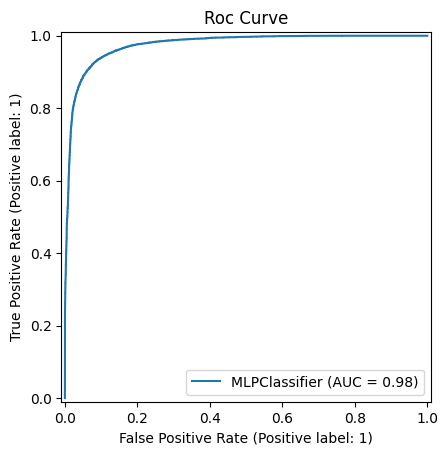

In [16]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(final_mlp_model, X_test, y_test)
plt.title('Roc Curve')
plt.show()

Text(0.5, 1.0, 'Confustion Matrix')

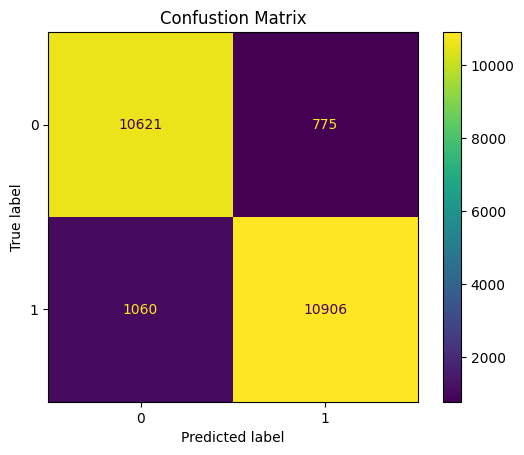

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_pred, y_test)
plt.title('Confustion Matrix')

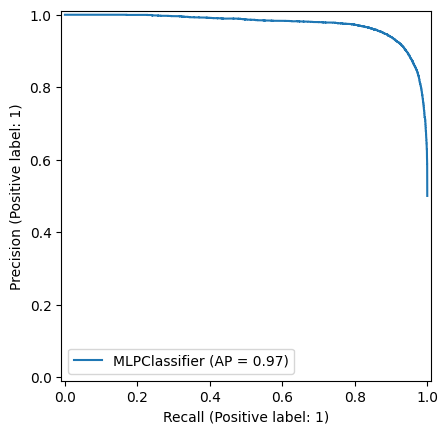

In [29]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(final_mlp_model, X_test, y_test)
plt.show()